In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

In [6]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20190908_fixedctrl/' #master folder
protein="WFA" #TNR,Agg,WFA,HABP

In [15]:
results = {"filename":[],"exp":[],
           "Manual mask from matlab GUI":[],
           "intensity":[],"int under mask":[],"bg sub int under mask":[],"bg sub int unmasked":[]}

histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
     #   if (protein in str(filelist[i]))==True:
            if ("TTX" in str(filelist[i]))==False:
                if filelist[i].endswith(".nd2"): 
                    results["filename"].append(filelist[i])
                    results["exp"].append(filelist[i].split('/')[-2])

In [16]:
print("\n".join(list(sorted(set(results["exp"])))))

background_atto647
background_autofluorescence
blk_plues12h
blk_plus0h
noblock_tnr647


In [17]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


In [18]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    #ecm_image=np.divide(ecm_image,16383.)
    
    #read masks
    
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
    ecm__bgreduced=deepcopy(ecm_image_raw)
    ecm__bgreduced=np.subtract(ecm__bgreduced,bg_somamask)
    ecm__bgreduced[ecm__bgreduced<0]=0
    
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)


        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    
        
    results["intensity"].append(ecm_image_raw.mean())
    results["bg sub int unmasked"].append(ecm__bgreduced.mean())
    if flag==True:
        results["int under mask"].append(ecm_image_raw[matlab_mask].mean())
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["int under mask"].append(np.nan)
        results["bg sub int under mask"].append(np.nan)

Total number of images: 148
Calculating image no 1 out of148
Calculating image no 2 out of148
Calculating image no 3 out of148
Calculating image no 4 out of148
Calculating image no 5 out of148
Calculating image no 6 out of148
Calculating image no 7 out of148
Calculating image no 8 out of148
Calculating image no 9 out of148
Calculating image no 10 out of148
Calculating image no 11 out of148
Calculating image no 12 out of148
Calculating image no 13 out of148
Calculating image no 14 out of148
Calculating image no 15 out of148
Calculating image no 16 out of148
Calculating image no 17 out of148
Calculating image no 18 out of148
Calculating image no 19 out of148
Calculating image no 20 out of148
Calculating image no 21 out of148
Calculating image no 22 out of148
Calculating image no 23 out of148
Calculating image no 24 out of148
Calculating image no 25 out of148
Calculating image no 26 out of148
Calculating image no 27 out of148
Calculating image no 28 out of148
Calculating image no 29 out o

In [19]:
df=pd.DataFrame(results)

In [20]:
df.columns

Index(['filename', 'exp', 'Manual mask from matlab GUI', 'intensity',
       'int under mask', 'bg sub int under mask', 'bg sub int unmasked'],
      dtype='object')

## quick look

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

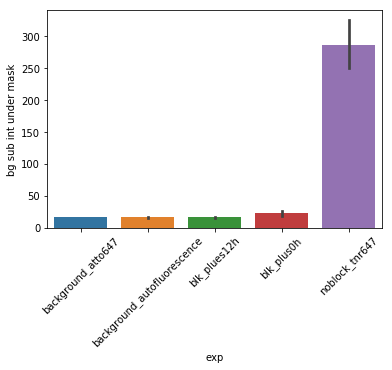

In [29]:
sns.barplot(x="exp",y="bg sub int under mask",data=df)
plt.xticks(rotation=45)

In [31]:
df["exp"].unique()

array(['background_atto647', 'background_autofluorescence',
       'blk_plues12h', 'blk_plus0h', 'noblock_tnr647'], dtype=object)

In [32]:
df2=deepcopy(df)
df2['Blocked or not']='None'
df2.loc[df2['exp'].str.contains('blk'), 'Blocked or not'] = 'Blocked'
df2.loc[df2['exp'].str.contains('no'), 'Blocked or not'] = 'Unblocked'

df2['Time']='Immediately'

df2['TNR or secondary']='None'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'

df2['expno']='None'
df2.loc[df2['filename'].str.contains('exp1'), 'expno'] = 'exp1'
df2.loc[df2['filename'].str.contains('exp2'), 'expno'] = 'exp2'
df2.loc[df2['filename'].str.contains('exp3'), 'expno'] = 'exp3'

df2["Condition"]='None'
df2.loc[df2['filename'].str.contains('background_atto647'), 'Condition'] = 'Background - Atto647'
df2.loc[df2['filename'].str.contains('background_autofluorescence'), 'Condition'] = 'Background - Autofluorescence'
df2.loc[df2['filename'].str.contains('blk_plues12h'), 'Condition'] = 'Block+12, TNR647'
df2.loc[df2['filename'].str.contains('blk_plus0h'), 'Condition'] = 'Block+0, TNR647'
df2.loc[df2['filename'].str.contains('noblock_tnr647'), 'Condition'] = 'Unblocked TNR647'




(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

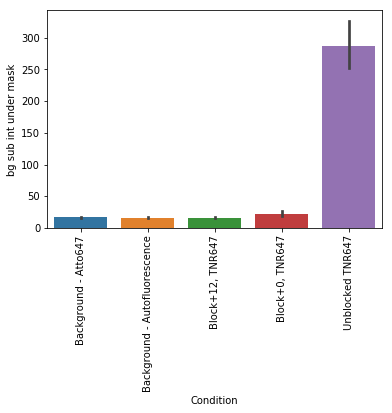

In [35]:
var="bg sub int under mask"
#var="intensity"
#var="int under mask"

sns.barplot(x="Condition",y=var,data=df2)
plt.xticks(rotation=90)

In [36]:

means={"expname":[],"Condition":[],"intensity":[]}

df2read=df2
           #& (df2["expname"]!="20181113_NCAN_analyse")]


for exp in df2read["expno"].unique():
    dfcalc=df2read[df2read["expno"]==exp]
    dfcalc=dfcalc.reset_index()
    for condition in dfcalc["Condition"].unique():
        dfcalc_cond=dfcalc[dfcalc["Condition"]==condition]
        means["expname"].append(exp)
        means["Condition"].append(condition)
        means["intensity"].append(dfcalc_cond[var].mean())
        means
    
    
    
dfmeans=pd.DataFrame(means)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

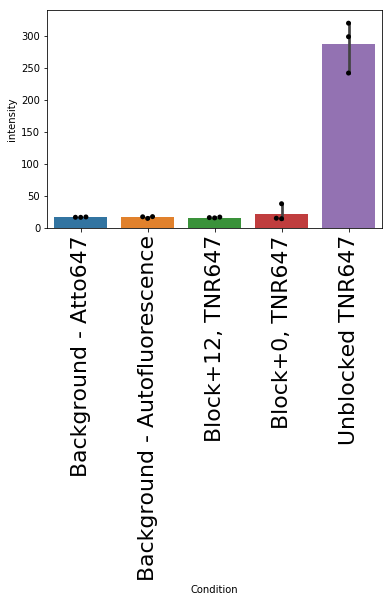

In [38]:
sns.barplot(data=dfmeans,x="Condition",y="intensity")
sns.swarmplot(data=dfmeans,x="Condition",y="intensity",color='black')
plt.xticks(rotation=90,fontsize=22)

## ttests

In [53]:
dfmeans[dfmeans["Condition"]=="Unblocked TNR647"]["intensity"].values

array([298.40875248, 319.55126565, 241.67401113])

In [51]:
dfmeans'Conidiotn'

,intensity
Condition,
Background - Atto647,16.577872
Background - Autofluorescence,16.438243
"Block+0, TNR647",22.241983
"Block+12, TNR647",16.053247
Unblocked TNR647,286.544676


In [78]:
from scipy import stats
negctrl=dfmeans[dfmeans["Condition"]=="Unblocked TNR647"]["intensity"].values
for item in ["Background - Autofluorescence","Background - Atto647","Block+0, TNR647","Block+12, TNR647"]:
    vals=dfmeans[dfmeans["Condition"]==item]["intensity"].values
    [stat, pval]=stats.ttest_ind(negctrl,vals)
    print('condition: '+item+' pval: '+str(pval))

condition: Background - Autofluorescence pval: 0.00031467350152498795
condition: Background - Atto647 pval: 0.0003144338949370929
condition: Block+0, TNR647 pval: 0.0004177336638004657
condition: Block+12, TNR647 pval: 0.0003121764356330408


## nice plot

In [43]:
dfmeans

,expname,Condition,intensity
0,exp1,Background - Atto647,16.355005
1,exp1,Background - Autofluorescence,17.467143
2,exp1,"Block+12, TNR647",16.749460
3,exp1,"Block+0, TNR647",37.588116
4,exp1,Unblocked TNR647,298.408752
5,exp2,Background - Atto647,16.439365
6,exp2,Background - Autofluorescence,14.651942
7,exp2,"Block+12, TNR647",15.921725
8,exp2,"Block+0, TNR647",14.941446
9,exp2,Unblocked TNR647,319.551266


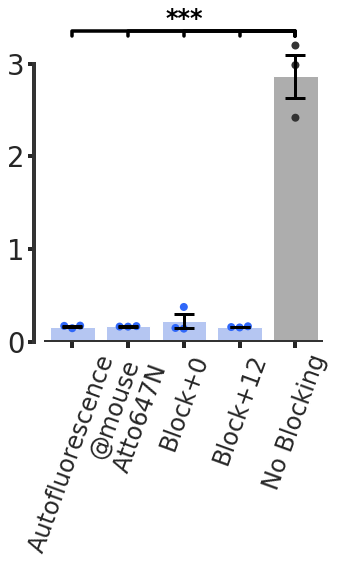

In [79]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(5,6))

df2plot=dfmeans
var='intensity'
order=['Background - Autofluorescence',
       'Background - Atto647',
      'Block+0, TNR647',
       'Block+12, TNR647',
       'Unblocked TNR647'
       ]

paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}


g=sns.barplot(data=df2plot,y=var,x="Condition"
            ,order=order,palette=palette,ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Condition"
            ,order=order,palette=paletteswarm,size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Condition"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Condition"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),['Autofluorescence',
                           '@mouse\nAtto647N',
      'Block+0',
       'Block+12',
       'No Blocking'
       ],
           rotation=70,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')


scale_x=100
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
x1, x2 = 0,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 1,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)

x1, x2 = 2,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)

x1, x2 = 3,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp1_fixedctrl.svg', bbox_inches='tight', format='svg')











## make df with intensity of each exp normalised to background

In [39]:
df2.columns

Index(['filename', 'exp', 'Manual mask from matlab GUI', 'intensity',
       'int under mask', 'bg sub int under mask', 'bg sub int unmasked',
       'Blocked or not', 'Time', 'TNR or secondary', 'expno', 'Condition'],
      dtype='object')

In [40]:
var="bg sub int under mask"
df_norms={"expname":[],"intensity norm2bg":[],"condition":[]}
for exp in df2["expno"].unique():
    dfexp=df2[df2["expno"]==exp]
    
    intensity_attounblocked=dfexp[dfexp["Condition"]=="Unblocked mouseAtto647"][var].mean()
    
    df_norms["intensity norm2bg"].append(1)
    df_norms["condition"].append("Background (atto647 mouse)")
    df_norms["expname"].append(exp)
    
    intensity_unblocked=dfexp[dfexp["Condition"]=="Unblocked TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_unblocked)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Unblocked TNR647")
    
    intensity_block0=dfexp[dfexp["Condition"]=="Block+0, TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_block0)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Block+0, TNR647")
    
    intensity_block12=dfexp[dfexp["Condition"]=="Block+12, TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_block12)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Block+12, TNR647")
    
df_norms=pd.DataFrame(df_norms)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

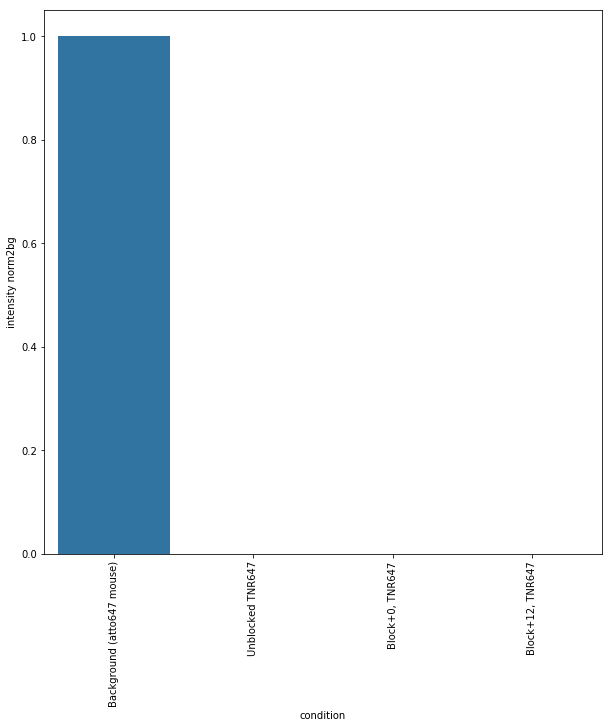

In [41]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_norms,x="condition",y="intensity norm2bg")
plt.xticks(rotation=90)

In [16]:
intensity_unblocked

2.857118023549687